# Lab 2: Bifurcations

## Problem 1 (4 points total)

You have been given signals of human brain activity obtained using an EEG.

The signal is received in two states - first, the subject solves a mathematical problem in his mind, then, having solved the problem, he stops thinking about anything :).

Your task is to find the bifurcation point in the brain activity of the subject - that is, the point at which the signal qualitatively changes its behavior.

In this case, it will be the point in time at which the person stopped solving the problem.

During this problem, you will be able to practice using Newton's method and searching for bifurcations on a one-dimensional problem, which will be very useful in the second task, which will be more difficult.

### Libraries

You are not allowed to use any other Python libraries except the ones listed below :(

In [2]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 43.7 MB/s eta 0:00:00


In [9]:
import os.path as osp
from matplotlib import pyplot as plt
import numpy as np
from numba import njit
from scipy.stats import gaussian_kde
from scipy.ndimage import uniform_filter1d
from scipy.interpolate import interp1d
from matplotlib.ticker import ScalarFormatter

import mne
from tqdm.auto import trange, tqdm
from warnings import filterwarnings
filterwarnings('ignore')

### Read data

In [2]:
path = osp.join("Brain_EEG.npy")
power = np.load(path, allow_pickle=True)
sample_freq = 500.
print(f"Signal sampling frequency={sample_freq} Hz")
power.shape

Signal sampling frequency=500.0 Hz


(700, 79694)

In [27]:
# Signal

### Problem 1.1 Let's look at the signal (1 point)

1. Implement a method for calculating the mean and variance of the signal frequency

2. Plot the signal power in the frequency domain, calculate the average and the variance of its frequency. To make the signal smoother, we will consider a window in the time domain, and average the signal power over time in this window. The choice of window width is yours.

In [3]:
@njit
def spectral_mean_std(omega_grid: np.ndarray, power_1d: np.ndarray):
    norm_power = power_1d / np.sum(power_1d)
    mean = np.sum(omega_grid * norm_power)
    variance = np.sum((omega_grid - mean)**2 * norm_power)
    std = np.sqrt(variance)
    return mean, std

Mean frequency: 3.61 Hz
Std (spectral width): 0.35 Hz


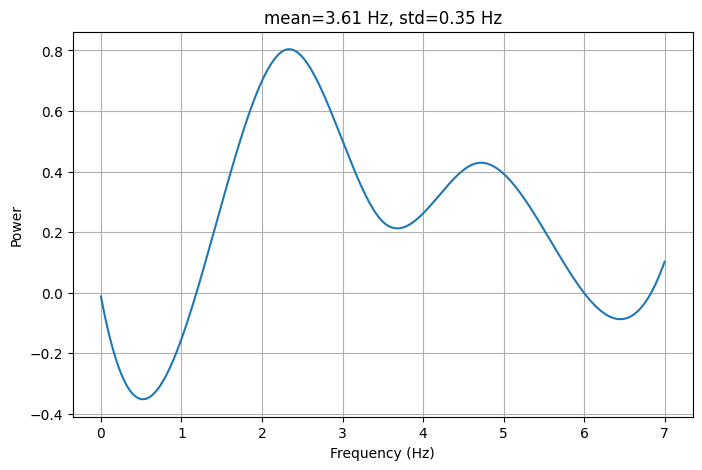

In [4]:
def plot_averaged_signal(power: np.ndarray, window_size: int):
    avg_spectrum = np.mean(power[:, :window_size], axis=1)
    edge_mean = (np.mean(avg_spectrum[:10]) + np.mean(avg_spectrum[-10:])) / 2
    avg_spectrum -= edge_mean
    omega_grid = np.linspace(0, 7, power.shape[0])
    mean, std = spectral_mean_std(omega_grid, avg_spectrum)
    plt.figure(figsize=(8, 5))
    plt.plot(omega_grid, avg_spectrum)
    plt.title(f"mean={mean:.2f} Hz, std={std:.2f} Hz")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.grid(True)

    print(f"Mean frequency: {mean:.2f} Hz")
    print(f"Std (spectral width): {std:.2f} Hz")
    plt.show()
plot_averaged_signal(power, window_size=1)


### Problem 1.2  Search for signal parameters using the Newton method (1 point)

As you can see from your graph above (you can move the window to see how the signal behaves), the brain activity signal in the frequency domain resembles a combination of one or two Gaussians. Therefore, we will model it exclusively in this way.

In particular, your task is to take two Gaussians with averages $\omega_1, \omega_2$, and find these two parameters that minimize the deviation of the simulated signal from the real one using the Newton method. The variance for each Gaussian can be taken, for example, equal to the variance of the entire signal.

Your tasks:

1. Consider functional - square of the norm ($L_2 - norm$) of the deviation of model signal from the real one.
$$
    ||f(x)||_2^2 = \int_a^b f^2(x) \: dx, \quad x \in [a,b]
$$
$\quad$ In our problem, this functional is essentially just a function of two variables $\omega_1, \omega_2$, and for them it is an integral with two parameters. Accordingly, write down (in words or $\LaTeX$ formula) the necessary first-order local minimum conditions for it (relative to $\omega_1, \omega_2$).

2. These two conditions will be the boundary conditions for our task. Now, using Newton's method, find the frequencies that minimize the functional for our signal model

P.S. In order not to look for a constant by which the signal power is shifted relative to zero, you can simply subtract the average of its values at the edges from the signal.

#### You need to implement the Newton's method and all the necessary functions yourself! To do this, from the libraries you can use only `numpy`, `numba`.

First, to make sure that your implementation is correct, find the correct frequencies for the signal for which you know them.

Iter 0: loss=62.919205, omega1=1.5161, omega2=4.3923
Iter 1: loss=24.286400, omega1=1.9345, omega2=4.8409
Iter 2: loss=1.341959, omega1=2.0008, omega2=4.9970
Iter 3: loss=0.000447, omega1=2.0000, omega2=5.0000
Iter 4: loss=0.000000, omega1=2.0000, omega2=5.0000


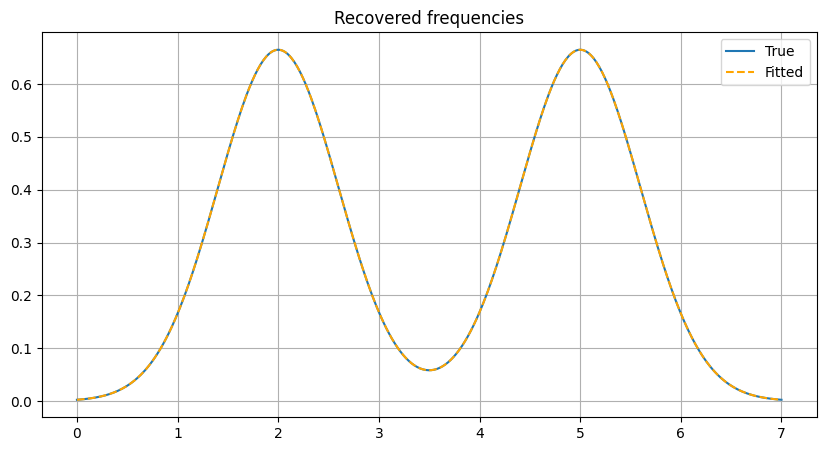

In [5]:
@njit
def normalized_gaussian(omega, omega0, sigma):
    coef = 1.0 / (np.sqrt(2 * np.pi) * sigma)
    return coef * np.exp(-0.5 * ((omega - omega0) / sigma)**2)
@njit
def model_signal(omega, omega1, omega2, sigma):
    return normalized_gaussian(omega, omega1, sigma) + normalized_gaussian(omega, omega2, sigma)

@njit
def compute_F(omega_grid, y_true, omega1, omega2, sigma):
    model = model_signal(omega_grid, omega1, omega2, sigma)
    return model - y_true

def approximate_jacobian(omega_grid, omega1, omega2, sigma, dx=1e-4):
    base_model = model_signal(omega_grid, omega1, omega2, sigma)

    model1 = model_signal(omega_grid, omega1 + dx, omega2, sigma)
    model2 = model_signal(omega_grid, omega1, omega2 + dx, sigma)

    dmodel_domega1 = (model1 - base_model) / dx
    dmodel_domega2 = (model2 - base_model) / dx

    J = np.zeros((2, 2))
    J[0, 0] = 2 * np.sum(dmodel_domega1 * dmodel_domega1)
    J[0, 1] = 2 * np.sum(dmodel_domega1 * dmodel_domega2)
    J[1, 0] = J[0, 1]
    J[1, 1] = 2 * np.sum(dmodel_domega2 * dmodel_domega2)
    return J, dmodel_domega1, dmodel_domega2

def newton_solver(omega_grid, y_true, omega1_init, omega2_init, sigma,
                  dx=1e-4, tol=1e-6, max_iter=100, verbose=True):
    omega1, omega2 = omega1_init, omega2_init

    for i in range(max_iter):
        F = compute_F(omega_grid, y_true, omega1, omega2, sigma)
        loss = np.sum(F**2)

        J, dF1, dF2 = approximate_jacobian(omega_grid, omega1, omega2, sigma, dx)

        grad = np.array([
            2 * np.sum(F * dF1),
            2 * np.sum(F * dF2)
        ])

        try:
            delta = np.linalg.solve(J, grad)
        except np.linalg.LinAlgError:
            print("Jacobian not invertible.")
            break

        omega1 -= delta[0]
        omega2 -= delta[1]

        if verbose:
            print(f"Iter {i}: loss={loss:.6f}, omega1={omega1:.4f}, omega2={omega2:.4f}")

        if np.linalg.norm(delta) < tol:
            break

    return omega1, omega2
omega_grid = np.linspace(0, 7, 500)
omega1_true, omega2_true = 2.0, 5.0
sigma = 0.6

y_true = model_signal(omega_grid, omega1_true, omega2_true, sigma)

omega1_init = 1.0
omega2_init = 4.0

omega1_fit, omega2_fit = newton_solver(
    omega_grid, y_true, omega1_init, omega2_init, sigma, dx=1e-4
)

y_fit = model_signal(omega_grid, omega1_fit, omega2_fit, sigma)

plt.figure(figsize=(10, 5))
plt.plot(omega_grid, y_true, label='True')
plt.plot(omega_grid, y_fit, '--', label='Fitted', color='orange')
plt.title("Recovered frequencies")
plt.legend()
plt.grid(True)
plt.show()


In [31]:
# Example

#### Now for real signal

Iter 0: loss=38.436373, omega1=2.9189, omega2=4.7711
Iter 1: loss=38.286564, omega1=1.8013, omega2=4.4129
Iter 2: loss=41.502442, omega1=3.0943, omega2=4.7840
Iter 3: loss=46.797742, omega1=1.8341, omega2=4.4941
Iter 4: loss=40.172834, omega1=3.0695, omega2=4.7936
Iter 5: loss=45.429664, omega1=1.8183, omega2=4.4711
Iter 6: loss=40.867368, omega1=3.0804, omega2=4.7904
Iter 7: loss=46.020929, omega1=1.8246, omega2=4.4804
Iter 8: loss=40.586813, omega1=3.0761, omega2=4.7918
Iter 9: loss=45.786626, omega1=1.8221, omega2=4.4767
Iter 10: loss=40.701121, omega1=3.0779, omega2=4.7912
Iter 11: loss=45.882715, omega1=1.8231, omega2=4.4782
Iter 12: loss=40.654731, omega1=3.0772, omega2=4.7915
Iter 13: loss=45.843829, omega1=1.8227, omega2=4.4776
Iter 14: loss=40.673587, omega1=3.0775, omega2=4.7914
Iter 15: loss=45.859652, omega1=1.8229, omega2=4.4778
Iter 16: loss=40.665927, omega1=3.0773, omega2=4.7914
Iter 17: loss=45.853228, omega1=1.8228, omega2=4.4777
Iter 18: loss=40.669039, omega1=3.0774

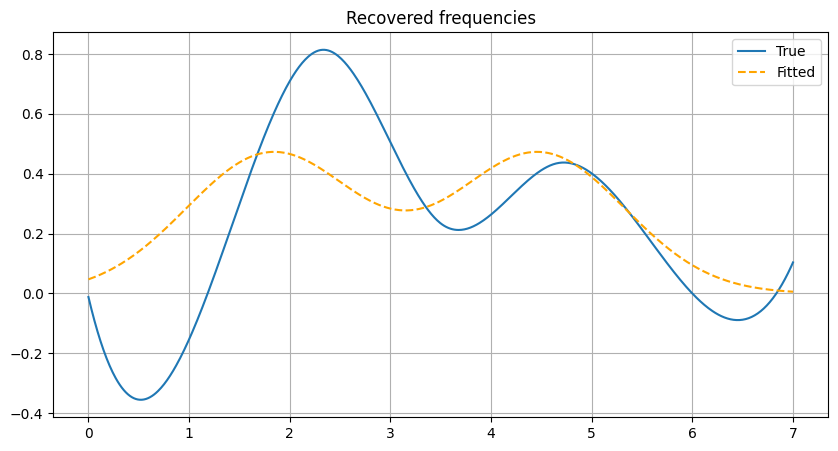

In [6]:
window_size = 60
start_idx = 60
avg_spectrum = np.mean(power[:, start_idx:start_idx + window_size], axis=1)

edge_mean = (np.mean(avg_spectrum[:10]) + np.mean(avg_spectrum[-10:])) / 2
y_true = avg_spectrum - edge_mean

omega_grid = np.linspace(0, 7, len(y_true))
sigma = 0.85
omega1_init, omega2_init = 2.0, 5.0
omega1_fit, omega2_fit = newton_solver(omega_grid, y_true, omega1_init, omega2_init, sigma)

y_fit = model_signal(omega_grid, omega1_fit, omega2_fit, sigma)

plt.figure(figsize=(10, 5))
plt.plot(omega_grid, y_true, label='True')
plt.plot(omega_grid, y_fit, '--', label='Fitted', color='orange')
plt.title("Recovered frequencies")
plt.legend()
plt.grid(True)
plt.show()


In [33]:
# Example

### Problem 1.3 (1 point)

In Newton's method, you considered the Jacobian approximation. Now, moving the window along the signal, plot the absolute values of determinants of the found Jacobians. Again, use only `numpy`, `numba`

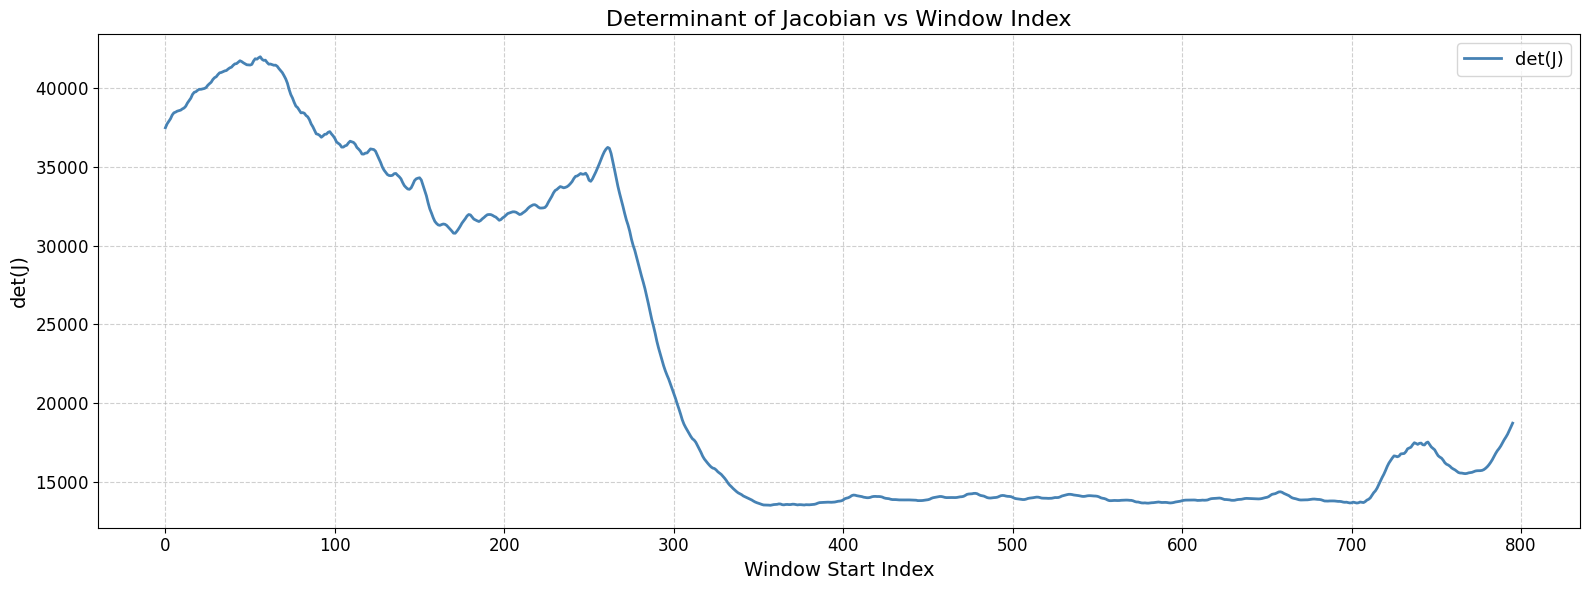

In [10]:
@njit
def normalized_gaussian(omega, omega0, sigma):
    coef = 1.0 / (np.sqrt(2 * np.pi) * sigma)
    return coef * np.exp(-0.5 * ((omega - omega0) / sigma)**2)

@njit
def model_signal(omega, omega1, omega2, sigma):
    return normalized_gaussian(omega, omega1, sigma) + normalized_gaussian(omega, omega2, sigma)

@njit
def compute_F(omega_grid, y_true, omega1, omega2, sigma):
    return model_signal(omega_grid, omega1, omega2, sigma) - y_true

def approximate_jacobian(func, omega1, omega2, dx, *args):
    F0 = func(omega1, omega2, *args)
    F1 = func(omega1 + dx, omega2, *args)
    F2 = func(omega1, omega2 + dx, *args)

    dF1 = (F1 - F0) / dx
    dF2 = (F2 - F0) / dx

    J = np.zeros((2, 2))
    J[0, 0] = np.sum(2 * dF1 * dF1)
    J[0, 1] = np.sum(2 * dF1 * dF2)
    J[1, 0] = J[0, 1]
    J[1, 1] = np.sum(2 * dF2 * dF2)
    return J

power = np.load("Brain_EEG.npy", allow_pickle=True)
power_down = power[:, ::100]
power_center = power_down[100:600, :]
n_freqs, n_times = power_center.shape
omega_grid = np.linspace(0, 7, n_freqs)

sigma = 0.85
dx = 1e-3
window_size = 1
det_vals = []

for t in range(n_times - window_size):
    window = power_center[:, t:t + window_size]
    avg_spectrum = np.mean(window, axis=1)
    baseline = (np.mean(avg_spectrum[:10]) + np.mean(avg_spectrum[-10:])) / 2
    y_true = avg_spectrum - baseline

    try:
        J = approximate_jacobian(compute_F, 2.0, 5.0, dx, omega_grid, y_true, sigma)
        det = np.linalg.det(J)
    except:
        det = 0.0
    det_vals.append(det)

det_vals = np.array(det_vals)
min_idx = np.argmin(det_vals)

plt.figure(figsize=(16, 6))
plt.plot(det_vals, label=r'det(J)', linewidth=2, color='steelblue')


plt.title("Determinant of Jacobian vs Window Index", fontsize=16)
plt.xlabel("Window Start Index", fontsize=14)
plt.ylabel(r"det(J)", fontsize=14)

plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=13)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [35]:
# Example

#### As you can see, the determinant reaches zero for the first time at some point.

(not exactly zero, but since we are approximating the Jacobian, we can assume that at the moment when the determinant reached the lowest value and began to increase back, it actually reached zero)

This point will be the bifurcation point, according to the theory of bifurcations.

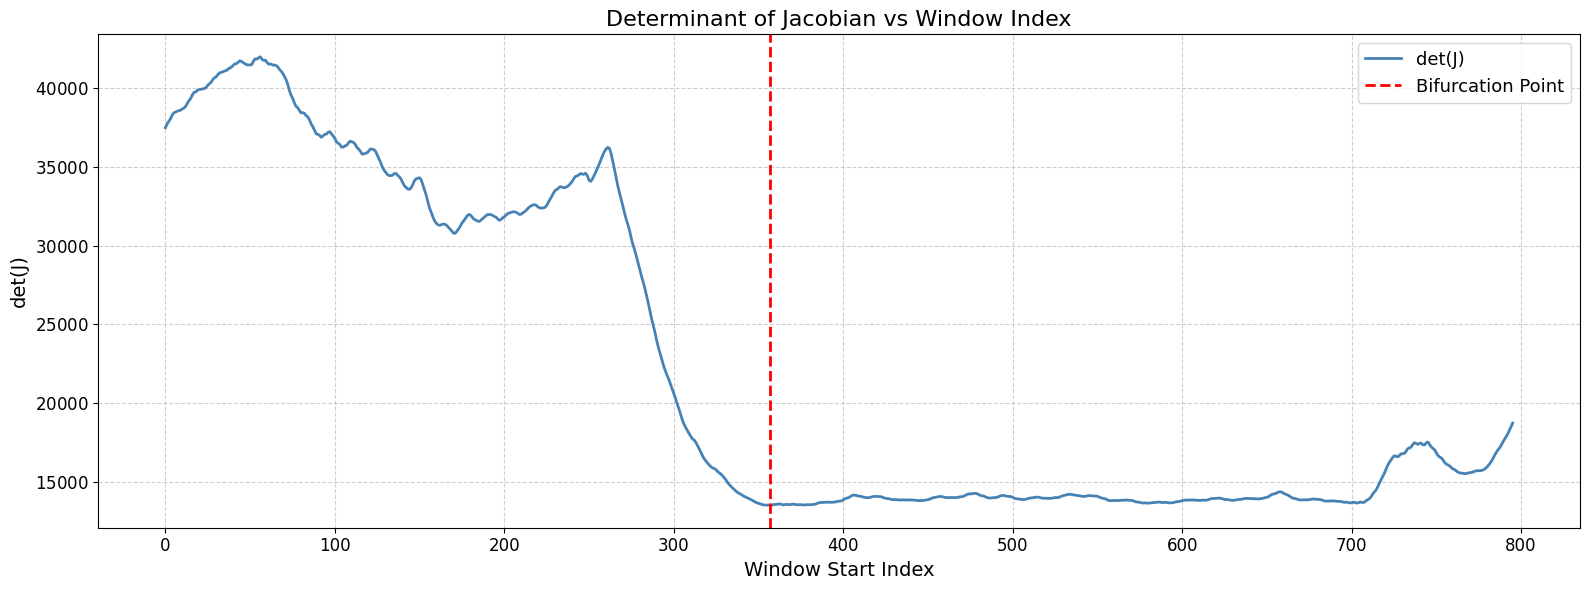

In [11]:
@njit
def normalized_gaussian(omega, omega0, sigma):
    coef = 1.0 / (np.sqrt(2 * np.pi) * sigma)
    return coef * np.exp(-0.5 * ((omega - omega0) / sigma)**2)

@njit
def model_signal(omega, omega1, omega2, sigma):
    return normalized_gaussian(omega, omega1, sigma) + normalized_gaussian(omega, omega2, sigma)

@njit
def compute_F(omega_grid, y_true, omega1, omega2, sigma):
    return model_signal(omega_grid, omega1, omega2, sigma) - y_true

def approximate_jacobian(func, omega1, omega2, dx, *args):
    F0 = func(omega1, omega2, *args)
    F1 = func(omega1 + dx, omega2, *args)
    F2 = func(omega1, omega2 + dx, *args)

    dF1 = (F1 - F0) / dx
    dF2 = (F2 - F0) / dx

    J = np.zeros((2, 2))
    J[0, 0] = np.sum(2 * dF1 * dF1)
    J[0, 1] = np.sum(2 * dF1 * dF2)
    J[1, 0] = J[0, 1]
    J[1, 1] = np.sum(2 * dF2 * dF2)
    return J
power = np.load("Brain_EEG.npy", allow_pickle=True)
power_down = power[:, ::100]
power_center = power_down[100:600, :]

n_freqs, n_times = power_center.shape
omega_grid = np.linspace(0, 7, n_freqs)

sigma = 0.85
dx = 1e-3
window_size = 1
det_vals = []
for t in range(n_times - window_size):
    window = power_center[:, t:t + window_size]
    avg_spectrum = np.mean(window, axis=1)
    baseline = (np.mean(avg_spectrum[:10]) + np.mean(avg_spectrum[-10:])) / 2
    y_true = avg_spectrum - baseline

    try:
        J = approximate_jacobian(compute_F, 2.0, 5.0, dx, omega_grid, y_true, sigma)
        det = np.linalg.det(J)
    except:
        det = 0.0
    det_vals.append(det)

det_vals = np.array(det_vals)
min_idx = np.argmin(det_vals)

plt.figure(figsize=(16, 6))
plt.plot(det_vals, label=r'det(J)', linewidth=2, color='steelblue')
plt.axvline(min_idx, color='red', linestyle='--', linewidth=2, label='Bifurcation Point')

plt.title("Determinant of Jacobian vs Window Index", fontsize=16)
plt.xlabel("Window Start Index", fontsize=14)
plt.ylabel(r"det(J)", fontsize=14)

plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=13)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [37]:
# Example

#### Problem 1.4 Plot the signal power in the frequency domain before, at, and after the bifurcation point. Draw conclusions. (1 point)

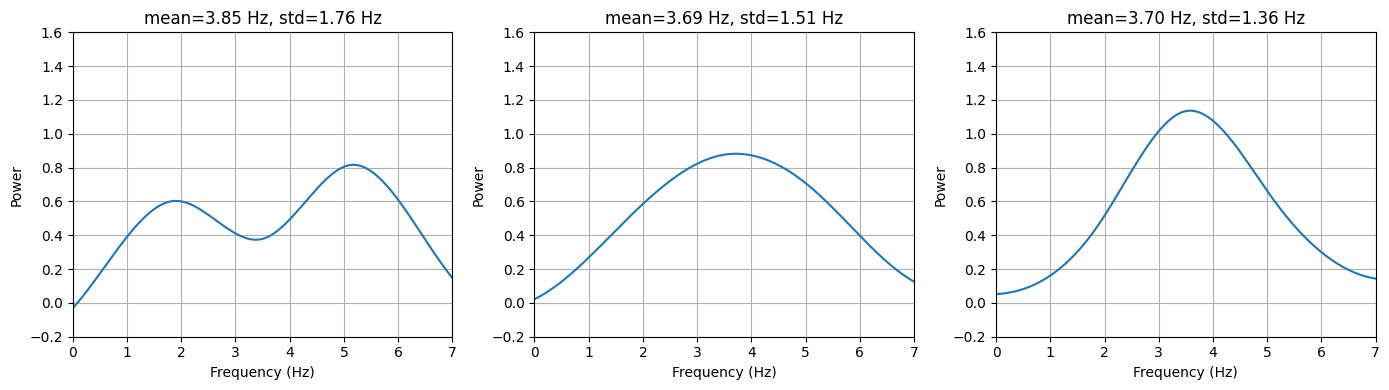

In [12]:
power_downsampled = power[:, ::100]
power_centered = power_downsampled[100:600, :]
n_freqs, n_times = power_centered.shape
omega_grid = np.linspace(0, 7, n_freqs)
def spectral_mean_std(omega_grid: np.ndarray, power_1d: np.ndarray):
    norm_power = power_1d / np.sum(power_1d)
    mean = np.sum(omega_grid * norm_power)
    variance = np.sum((omega_grid - mean)**2 * norm_power)
    std = np.sqrt(variance)
    return mean, std
window_size = 50
center_indices = [200, 280, 300]

plt.figure(figsize=(14, 4))

for i, center in enumerate(center_indices):
    window = power_centered[:, center:center + window_size]
    avg_power = np.mean(window, axis=1)
    mean, std = spectral_mean_std(omega_grid, avg_power)

    plt.subplot(1, 3, i+1)
    plt.plot(omega_grid, avg_power)
    plt.ylim(-0.2, 1.6)
    plt.xlim(0, 7)
    plt.grid(True)
    plt.title(f"mean={mean:.2f} Hz, std={std:.2f} Hz")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")

plt.tight_layout()
plt.show()

#### P.S. You should obtain something like this

In [39]:
# Пример работы

## Problem 2: 2D Bratu problem (6 points total)

You have been given a two-dimensional Bratu problem (yes, the one from the seminars):

$$\int_0^1 \int_0^1 \lambda e^u - \frac{1}{2} \left(\left(\frac{\partial u}{\partial x}\right)^2 + \left(\frac{\partial u}{\partial y}\right)^2\right) dxdy \longrightarrow \underset{u}{extr}$$
$$s.t.$$
$$u(0,y)=u(1,y)=u(x,0)=u(x,1)=0$$


1. (2 points) Using the generalised iterative Kantorovich method (it can be used with one term - $u(x,y) = h(x)g(y)$), solve the problem for $\lambda = 1$.
2. (4 points) Conduct bifurcation analysis for the Bratu problem. So, you need to construct two plots:
   1. $\lambda$ vs. determinant of the Jacobian matrix
   2. $\lambda$ vs. $\|u\|_\infty$

**P.S.**

You should have one critical point around $\lambda \approx 7.0$

**P.P.S.**

To simplify your task, instead of $e^u$, you can substitute its expansion in the Taylor series up to the third term: $e^u\approx 1 + u +\frac{u^2}{2!} + \frac{u^3}{3!}$. But then the critical point can shift. We will not reduce points for such a substitution!

In [16]:
import numpy as np
from scipy.integrate import dblquad
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt
import scipy.sparse
import scipy.sparse.linalg
from tqdm.notebook import tqdm
from matplotlib import gridspec


Solved coefficient for λ=1: C = 1.317888


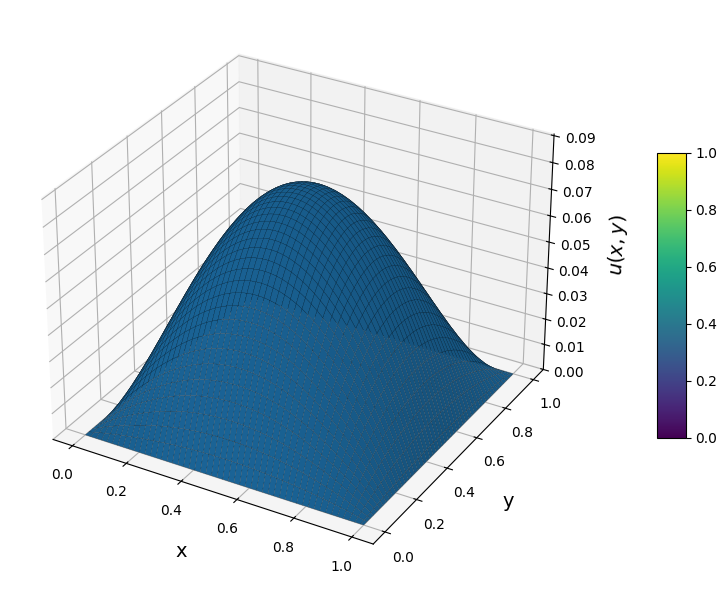

In [17]:
def phi(x, y):
    """Basis function x(1-x)y(1-y)."""
    return x * (1 - x) * y * (1 - y)
def grad_phi_sq(x, y):
    """Squared norm of the gradient of phi."""
    phi_x = (1 - 2*x) * y * (1 - y)
    phi_y = x * (1 - x) * (1 - 2*y)
    return phi_x**2 + phi_y**2

def equation_for_C(C, lam):
    integrand_lambda_part = lambda x, y: lam * (phi(x, y) + C * phi(x, y)**2 + (C**2 / 2.0) * phi(x, y)**3)
    integrand_grad_part = lambda x, y: C * grad_phi_sq(x, y)
    integral_lambda, _ = dblquad(integrand_lambda_part, 0, 1, lambda y: 0, lambda y: 1)
    integral_grad, _ = dblquad(integrand_grad_part, 0, 1, lambda y: 0, lambda y: 1)

    return integral_lambda - integral_grad
try:
    sol = root_scalar(equation_for_C, args=(1.0,), bracket=[0, 5], method='brentq')
    C_sol_lam1 = sol.root
    print(f"Solved coefficient for λ=1: C = {C_sol_lam1:.6f}")

    x = np.linspace(0, 1, 100)
    y = np.linspace(0, 1, 100)
    X, Y = np.meshgrid(x, y)
    Z = C_sol_lam1 * phi(X, Y)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    surface = ax.plot_surface(X, Y, Z, edgecolor='k', linewidth=0.1, antialiased=True)

    ax.set_xlabel('x', fontsize=14, labelpad=10)
    ax.set_ylabel('y', fontsize=14, labelpad=10)
    ax.set_zlabel(r'$u(x,y)$', fontsize=14, labelpad=10)

    ax.set_zlim(0, np.max(Z)*1.1)

    fig.colorbar(surface, ax=ax, shrink=0.5, aspect=10, pad=0.1)

    plt.tight_layout()
    plt.show()

except ValueError as e:
    print(f"Root finding failed: {e}")

2. (4 points) Conduct bifurcation analysis for the Bratu problem. So, you need to construct two plots:
   1. $\lambda$ vs. determinant of the Jacobian matrix
   2. $\lambda$ vs. $\|u\|_\infty$

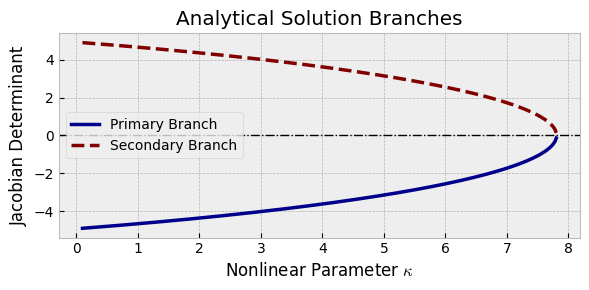

In [18]:
PI2 = np.pi ** 2

def compute_roots(k):
    a = k * 8 / (9 * PI2)
    b = k / 4 - PI2 / 2
    c = k * 4 / PI2
    D = b**2 - 4*a*c
    if D < 0:
        return []
    sqrt_D = np.sqrt(D)
    roots = [(-b + sqrt_D) / (2 * a), (-b - sqrt_D) / (2 * a)]
    return sorted([r for r in roots if r > 1e-9])

def evaluate_jacobian(k, u_val):
    if u_val is None or np.isnan(u_val):
        return np.nan
    return k * (0.25 + 16 * u_val / (9 * PI2)) - PI2 / 2

def nonlinear_solver(grid_size, k, init_guess=None, tol=1e-8, max_iter=50):
    h = 1.0 / (grid_size - 1)
    n = (grid_size - 2)**2
    A = scipy.sparse.lil_matrix((n, n))

    for r in range(grid_size - 2):
        for c in range(grid_size - 2):
            idx = r * (grid_size - 2) + c
            A[idx, idx] = -4
            if r > 0: A[idx, idx - (grid_size - 2)] = 1
            if r < grid_size - 3: A[idx, idx + (grid_size - 2)] = 1
            if c > 0: A[idx, idx - 1] = 1
            if c < grid_size - 3: A[idx, idx + 1] = 1

    A = (A / h**2).tocsc()
    sol = np.zeros(n) if init_guess is None else init_guess.copy()

    for _ in range(max_iter):
        f = np.exp(sol)
        residual = A @ sol + k * f
        if np.linalg.norm(residual, np.inf) < tol:
            break
        J = A + scipy.sparse.diags(k * f)
        try:
            delta = scipy.sparse.linalg.spsolve(J, -residual)
        except Exception:
            return None, None, None
        sol += delta
        if np.linalg.norm(delta, np.inf) < tol:
            break
    else:
        return None, None, None

    final_J = A + scipy.sparse.diags(k * np.exp(sol))
    sign, logdet = np.linalg.slogdet(final_J.toarray())
    return sol, sign, logdet

def continuation_method(grid_size, start_sol, start_k, ds, total_steps):
    h = 1.0 / (grid_size - 1)
    n = (grid_size - 2)**2
    L = scipy.sparse.lil_matrix((n, n))

    for r in range(grid_size - 2):
        for c in range(grid_size - 2):
            idx = r * (grid_size - 2) + c
            L[idx, idx] = -4
            if r > 0: L[idx, idx - (grid_size - 2)] = 1
            if r < grid_size - 3: L[idx, idx + (grid_size - 2)] = 1
            if c > 0: L[idx, idx - 1] = 1
            if c < grid_size - 3: L[idx, idx + 1] = 1

    L = (L / h**2).tocsc()
    k_vals = [start_k]
    max_sols = [np.max(np.abs(start_sol))]
    logs = []
    signs = []

    u = start_sol.copy()
    k = start_k
    du = np.zeros(n)
    dk = 1.0

    for _ in range(total_steps):
        up = u + ds * du
        kp = k + ds * dk
        u_temp, k_temp = up, kp

        for _ in range(10):
            ef = np.exp(u_temp)
            res = L @ u_temp + k_temp * ef
            constraint = du @ (u_temp - u) + dk * (k_temp - k) - ds
            if np.linalg.norm(res, np.inf) < 1e-8 and abs(constraint) < 1e-8:
                break
            J = L + scipy.sparse.diags(k_temp * ef)
            dfdk = ef
            v1 = scipy.sparse.linalg.spsolve(J, -res)
            v2 = scipy.sparse.linalg.spsolve(J, dfdk)
            dk_step = (constraint - du @ v1) / (dk - du @ v2)
            du_step = v1 - dk_step * v2
            u_temp += du_step
            k_temp += dk_step
        else:
            break

        u, k = u_temp, k_temp
        J_current = L + scipy.sparse.diags(k * np.exp(u))
        try:
            dudk = scipy.sparse.linalg.spsolve(J_current, -np.exp(u))
        except Exception:
            break

        norm = 1.0 / np.sqrt(1 + np.dot(dudk, dudk))
        dk_new = norm
        du_new = dudk * norm

        if np.dot(du, du_new) + dk * dk_new < 0:
            du_new *= -1
            dk_new *= -1

        du, dk = du_new, dk_new
        sign, logdet = np.linalg.slogdet(J_current.toarray())

        k_vals.append(k)
        max_sols.append(np.max(np.abs(u)))
        logs.append(logdet)
        signs.append(sign)

    return np.array(k_vals), np.array(max_sols), np.array(logs), np.array(signs)
param_grid = np.linspace(0.1, 8.0, 400)
root1 = np.full_like(param_grid, np.nan)
root2 = np.full_like(param_grid, np.nan)
jac1 = np.full_like(param_grid, np.nan)
jac2 = np.full_like(param_grid, np.nan)

for i, k_val in enumerate(param_grid):
    found = compute_roots(k_val)
    if found:
        root1[i] = found[0]
        jac1[i] = evaluate_jacobian(k_val, found[0])
        if len(found) > 1:
            root2[i] = found[1]
            jac2[i] = evaluate_jacobian(k_val, found[1])
GRID = 20
init_u, _, _ = nonlinear_solver(GRID, 0.1)
k_series, u_maxima, logdets, _ = continuation_method(GRID, init_u, 0.1, 0.5, 160)

plt.style.use('bmh')
plt.figure(figsize=(6, 3))
plt.plot(param_grid, jac1, label='Primary Branch', color='darkblue', linewidth=2.5)
plt.plot(param_grid, jac2, label='Secondary Branch', color='maroon', linestyle='--', linewidth=2.5)
plt.axhline(0, color='black', linestyle='-.', linewidth=1)
plt.xlabel(r'Nonlinear Parameter $\kappa$')
plt.ylabel('Jacobian Determinant')
plt.title('Analytical Solution Branches')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



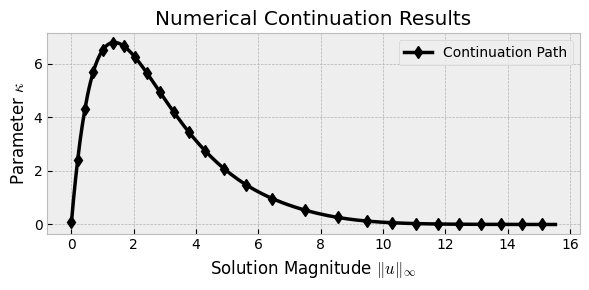

In [19]:
plt.figure(figsize=(6, 3))
plt.plot(u_maxima, k_series, label='Continuation Path', color='black', marker='d',
         linewidth=2.5, markersize=6, markevery=6)
plt.xlabel(r'Solution Magnitude $\|u\|_{\infty}$')
plt.ylabel(r'Parameter $\kappa$')
plt.title('Numerical Continuation Results')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()